# MCMC model using Julia

In [1]:
# Import the relevant libraries.
import AbstractMCMC
import StatsBase
using Distributions
using Random
using LinearAlgebra
import MCMCChains
using DataFrames, CSV
using wgregseq
using Revise
using KernelDensity
using CairoMakie
using SparseArrays
using TickTock

#CairoMakie.activate!()

#wgregseq.plotting_style.default_makie!()

## Import data

In [2]:
df_map = CSV.read(
    "../../../data/barcodes/20220514_mapping/mapped_barcodes.csv", 
    DataFrame, 
);

# Filter out unnannotad sequences
df_map = df_map[df_map.name .!= "*", :]

# Filter out non-unique barcodes
gdf = groupby(df_map[(df_map.map_count .> 2), :], :barcode)
_df = DataFrame()
for df in gdf
    if nrow(df) == 1
        append!(_df, df)
    end
end
df_map = copy(_df);

# Get twist order to get wild type sequences
df_seqs = wgregseq.utils.import_twist_order("../../../data/twist_orders/2022-02-15_twist_order.csv")
df_wt = df_seqs[1:1501:119*1501, :];
insertcols!(df_wt, 4, :promoter_seq => [string(x[27:186]) for x in df_wt.sequence])

df_wt.promoter_seq |> unique |> length
df_map = leftjoin(df_map, rename(df_wt[!, [:promoter, :promoter_seq]], :promoter => :name), on="name")
rename!(df_map, :promoter_seq => :wt_seq);

In [3]:
function get_dataset(i)
    df_DNA = CSV.read(
        "../../../data/extracted_barcodes/20230907_barcode/D$(i)_collapsed.txt", 
        DataFrame, 
        ignorerepeated=true, 
        delim=" ", 
        header=["ct_0", "barcode"]
    )
    # import RNA
    df_RNA = CSV.read(
        "../../../data/extracted_barcodes/20230907_barcode/R$(i)_collapsed.txt", 
        DataFrame, 
        ignorerepeated=true, 
        delim=" ", 
        header=["ct_1", "barcode"]
    )
    
    # merge DNA and RNA reads
    df = outerjoin(df_DNA, df_RNA, on=:barcode)
    
    # replace missing reads with 0
    replace!(df.ct_0, missing => 0)
    replace!(df.ct_1, missing => 0)
    
    # identify promoter sequences
    df = innerjoin(df, df_map, on=:barcode)
    
    # compute total counts
    insertcols!(df, 1, :ct => df.ct_0 .+ df.ct_1)
    insertcols!(df, 1, :relative_counts => (df.ct_1 .+ 1) ./ (df.ct_0 .+ 1))
    
    # Turn sequences into integer
    insertcols!(df, 3, :int_promoter => wgregseq.footprints.make_int.(df[:, :promoter]))
    insertcols!(df, 3, :int_wt => wgregseq.footprints.make_int.(df[:, :wt_seq]));
    return df
end

get_dataset (generic function with 1 method)

In [94]:
df = get_dataset(3);
df = df[df.name .== "araBp", :];

In [95]:
seq_vec_0 = vcat([fill(i, df.ct_0[i]) for i in 1:nrow(df)]...)
mu0 = fill(0, length(seq_vec_0))

seq_vec_1 = vcat([fill(i, df.ct_1[i]) for i in 1:nrow(df)]...)
mu1 = fill(1, length(seq_vec_1))

seq_vec = vcat(seq_vec_0, seq_vec_1)
mu = vcat(mu0, mu1)
mu = log10.((df.ct_1 .+ 1) ./ (df.ct_0 .+ 1))
seq_mat = sparse(vcat([vcat(wgregseq.utils.onehot_encoder.(seq)'...)' for seq in df.promoter]...));

In [96]:
# Define a sampler type.
mutable struct MetropolisHastings{T, D, C} <: AbstractMCMC.AbstractSampler 
    init_θ::T
    proposal::D
    sigma::C
end

# Default constructors.
MetropolisHastings(init_θ::Matrix{<:Real}) = MetropolisHastings(init_θ, reshape(MvNormal(zero(vec(init_θ)), I), 4, 160), 1.)

MetropolisHastings

In [97]:
MetropolisHastings(rand(4, 160))

MetropolisHastings{Matrix{Float64}, MatrixReshaped{Continuous, IsoNormal}, Float64}([0.3293929756275419 0.033547262208247663 … 0.8068821641057369 0.07268517433209165; 0.04543907535920566 0.22353437721423908 … 0.6722406408421263 0.5231866206940357; 0.6421862751544661 0.5023890044122213 … 0.06632079426213322 0.40691205459747815; 0.3095318153956128 0.1837641512399253 … 0.3426951465495913 0.07386612595088649], MatrixReshaped{Continuous, IsoNormal}(
dist: IsoNormal(
dim: 640
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]
)

dims: (4, 160)
)
, 1.0)

In [98]:
# Define a model type. Stores the log density function.
struct DensityModel{F<:Function} <: AbstractMCMC.AbstractModel
    ℓπ::F
    mu_arr::AbstractArray
    seq_mat
end


In [99]:
struct Transition{T, L}
    θ::T
    lp::L
end

# Store the new draw and its log density.
Transition(model::DensityModel, θ) = Transition(θ, ℓπ(model, θ))

Transition

In [100]:
# Define the first step! function, which is called at the 
# beginning of sampling. Return the initial parameter used
# to define the sampler.
function AbstractMCMC.step(
    rng::AbstractRNG,
    model::DensityModel,
    spl::MetropolisHastings,
    kwargs...
)   
    return Transition(model, spl.init_θ), spl
end

In [101]:
# Define a function that makes a basic proposal depending on a univariate
# parameterization or a multivariate parameterization.

propose(spl::MetropolisHastings, model::DensityModel, θ::Matrix{<:Real}) = 
    Transition(model, wgregseq.footprints.gauge_emat(θ + rand(spl.proposal)))
propose(spl::MetropolisHastings, model::DensityModel, t::Transition) =
    propose(spl, model, t.θ)

# Calculates the probability `q(θ|θcond)`, using the proposal distribution `spl.proposal`.
q(spl::MetropolisHastings, θ::Matrix{<:Real}, θcond::Matrix{<:Real}) =
    logpdf(spl.proposal, θ - θcond)
q(spl::MetropolisHastings, t1::Transition, t2::Transition) = q(spl, t1.θ, t2.θ)

# Calculate the density of the model given some parameterization.
ℓπ(model::DensityModel, θ) = model.ℓπ(model.seq_mat, model.mu_arr, θ)
ℓπ(model::DensityModel, T::Transition) = model.ℓπ(model.seq_mat, model.mu_arr, T.θ)

ℓπ (generic function with 2 methods)

In [102]:

# Define the other step function. Returns a Transition containing
# either a new proposal (if accepted) or the previous proposal 
# (if not accepted).
function AbstractMCMC.step(
    rng::AbstractRNG,
    model::DensityModel,
    spl::MetropolisHastings,
    θ_prev_T::Transition,
    ;
    kwargs...
)
    # Generate a new proposal.
    θ_T = propose(spl, model, θ_prev_T)
    # Calculate the log acceptance probability.
    α = ℓπ(model, θ_T) - ℓπ(model, θ_prev_T) + q(spl, θ_prev_T, θ_T) - q(spl, θ_T, θ_prev_T)

    # Decide whether to return the previous θ or the new one.
    #if log(rand(rng)) < min(α, 0.0)
    if log(rand(rng)) < min(α, 0.0)
        return θ_T, spl, true
    else
        return θ_prev_T, spl, false
    end
end

In [103]:
function density(seq_mat, mu::Vector{Float64}, θ::Matrix{Float64})
    en = (seq_mat * vec(θ))
    y = kde((en, mu), npoints=(10, 512))
    y.density ./= sum(y.density)
    return wgregseq.footprints.mutual_information_add_model(y.density)
end

# Construct a DensityModel.
model = DensityModel(density, mu, seq_mat)

# Set up our sampler with initial parameters.
spl = MetropolisHastings(randn(4, 160))

MetropolisHastings{Matrix{Float64}, MatrixReshaped{Continuous, IsoNormal}, Float64}([0.4137641954088161 0.015211232647360781 … -0.7230099120104091 -0.029774745144764813; -0.25220876828966365 -0.4572251781735096 … -0.23418150266436027 -0.2679202093462902; -1.3839281908841508 -0.5096043686596554 … 0.9418514225881085 -0.7477000649022743; -1.1159978164249822 0.12446545098276338 … -2.5222638040282943 0.5885267461310189], MatrixReshaped{Continuous, IsoNormal}(
dist: IsoNormal(
dim: 640
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]
)

dims: (4, 160)
)
, 1.0)

In [104]:
θ_prev_T = Transition(model, randn(4, 160))
θ_T = propose(spl, model, θ_prev_T)

ℓπ(model, θ_T) - ℓπ(model, θ_prev_T) + q(spl, θ_prev_T, θ_T) - q(spl, θ_T, θ_prev_T)

-0.002499349141771745

In [105]:
function AbstractMCMC.bundle_samples(
    ℓ::DensityModel, 
    s::MetropolisHastings, 
    N::Integer, 
    ts::Vector{<:Transition},
    chain_type::Type{Any};
    param_names=missing,
    kwargs...
)
    # Turn all the transitions into a vector-of-vectors.
    vals = copy(reduce(hcat,[vcat(vec(t.θ), t.lp) for t in ts])')

    # Check if we received any parameter names.
    if ismissing(param_names)
        param_names = ["Parameter $i" for i in 1:(length(first(vals))-1)]
    end

    # Add the log density field to the parameter names.
    push!(param_names, "lp")

    # Bundle everything up and return a Chains struct.
    return vals, param_names
end

In [106]:
function adapt_sigma(rate)
    if rate < 0.001
        return 0.1
    elseif rate < 0.05
        return 0.5
    elseif rate < 0.2 
        return 0.9
    elseif rate > 0.5
        return 1.1
    elseif rate > 0.75
        return 2
    elseif rate > 0.95
        return 10
    else
        return 1
    end
end

adapt_sigma (generic function with 1 method)

In [107]:
function StatsBase.sample(
    model::AbstractMCMC.AbstractModel,
    sampler::AbstractMCMC.AbstractSampler,
    nsamples::Integer,
    seq_mat,
    rng::Random.AbstractRNG=Random.default_rng(),
    ;
    kwargs...
)
    # Obtain the initial sample and state.
    sample, sampler = AbstractMCMC.step(rng, model, sampler; kwargs...)

    ## Save the sample.
    samples = AbstractMCMC.samples(sample, model, sampler, nsamples; kwargs...)
    samples = AbstractMCMC.save!!(samples, sample, 1, model, sampler, nsamples; kwargs...)
    tick()
    # Step through the sampler.
    acceptance = 0
    for i in 2:nsamples
        # Obtain the next sample and state.
        sample, sampler, accept = AbstractMCMC.step(rng, model, sampler, sample; kwargs...)
        acceptance += accept
        # Save the sample.
        samples = AbstractMCMC.save!!(samples, sample, i, model, sampler, nsamples; kwargs...)
        if i%1000 == 0
            println("$i of $nsamples done.")
            laptimer()
            println(density(model.seq_mat, model.mu_arr, sample.θ))
            spl.sigma *= adapt_sigma(acceptance/1000)
            acceptance = 0
            spl.proposal = reshape(MvNormal(zeros(640), I * spl.sigma), 4, 160)
        end
    end
    tock()

    return AbstractMCMC.bundle_samples(model, sampler, nsamples, samples, Any; kwargs...)
end

In [108]:
tock()

LoadError: Use `tick()` to start a timer.

In [109]:
chain = StatsBase.sample(model, spl, 500000, seq_mat)

[ Info:  started timer at: 2023-09-19T08:29:27.732


1000 of 100000 done.
1         0.006273699255955395


[ Info:           5.96029425s: 5 seconds, 960 milliseconds


2000 of 100000 done.
1         0.005922124783295988


[ Info:         11.572199375s: 11 seconds, 572 milliseconds


3000 of 100000 done.
1         0.006650738336499821


[ Info:            17.105202s: 17 seconds, 105 milliseconds


4000 of 100000 done.
1         0.004411997824391126


[ Info:         22.471358875s: 22 seconds, 471 milliseconds


5000 of 100000 done.
1         0.008334032807924885


[ Info:           28.0003245s: 28 seconds


6000 of 100000 done.
1         0.009392073322474142


[ Info:         33.575956125s: 33 seconds, 575 milliseconds


7000 of 100000 done.
1         0.006711155010402672


[ Info:         38.932607459s: 38 seconds, 932 milliseconds


8000 of 100000 done.
1         0.005911497989518725


[ Info:         44.438613792s: 44 seconds, 438 milliseconds


9000 of 100000 done.
1         0.004728134889974081


[ Info:          49.98835925s: 49 seconds, 988 milliseconds


10000 of 100000 done.
1         0.007456869342605078


[ Info:         55.324797667s: 55 seconds, 324 milliseconds


11000 of 100000 done.
1         0.007332713100674451


[ Info:            60.850745s: 1 minute, 850 milliseconds


12000 of 100000 done.
1         0.00786336482800263


[ Info:         66.331669042s: 1 minute, 6 seconds, 331 milliseconds


13000 of 100000 done.
1         0.0038931851819863123


[ Info:         71.786414334s: 1 minute, 11 seconds, 786 milliseconds


14000 of 100000 done.
1         0.008727388826648981


[ Info:         77.472715709s: 1 minute, 17 seconds, 472 milliseconds


15000 of 100000 done.
1         0.005525597335817188


[ Info:         83.144261959s: 1 minute, 23 seconds, 144 milliseconds


16000 of 100000 done.
1         0.008281266897196188


[ Info:         88.610933292s: 1 minute, 28 seconds, 610 milliseconds


17000 of 100000 done.
1         0.00577519647932765


[ Info:          94.27720675s: 1 minute, 34 seconds, 277 milliseconds


18000 of 100000 done.
1         0.006733479150473826


[ Info:        100.057470292s: 1 minute, 40 seconds, 57 milliseconds


19000 of 100000 done.
1         0.0052423277888916054


[ Info:        105.780916292s: 1 minute, 45 seconds, 780 milliseconds


20000 of 100000 done.
1         0.004789759366341057


[ Info:        111.127342334s: 1 minute, 51 seconds, 127 milliseconds


21000 of 100000 done.
1         0.005030183918601845


[ Info:        116.724971709s: 1 minute, 56 seconds, 724 milliseconds


22000 of 100000 done.
1         0.009519966308781155


[ Info:        122.410683625s: 2 minutes, 2 seconds, 410 milliseconds


23000 of 100000 done.
1         0.004651183551885735


[ Info:        127.892362959s: 2 minutes, 7 seconds, 892 milliseconds


24000 of 100000 done.
1         0.006021324957282636


[ Info:         133.57197575s: 2 minutes, 13 seconds, 571 milliseconds


25000 of 100000 done.
1         0.0050440252987073945


[ Info:        139.293639417s: 2 minutes, 19 seconds, 293 milliseconds


26000 of 100000 done.
1         0.006575470907201158


[ Info:        144.719108417s: 2 minutes, 24 seconds, 719 milliseconds


27000 of 100000 done.
1         0.007913706494842576


[ Info:        150.352696292s: 2 minutes, 30 seconds, 352 milliseconds


28000 of 100000 done.
1         0.0058648287098155664


[ Info:        155.951011917s: 2 minutes, 35 seconds, 951 milliseconds


29000 of 100000 done.
1         0.005845006722950675


[ Info:        161.327048167s: 2 minutes, 41 seconds, 327 milliseconds


LoadError: InterruptException:

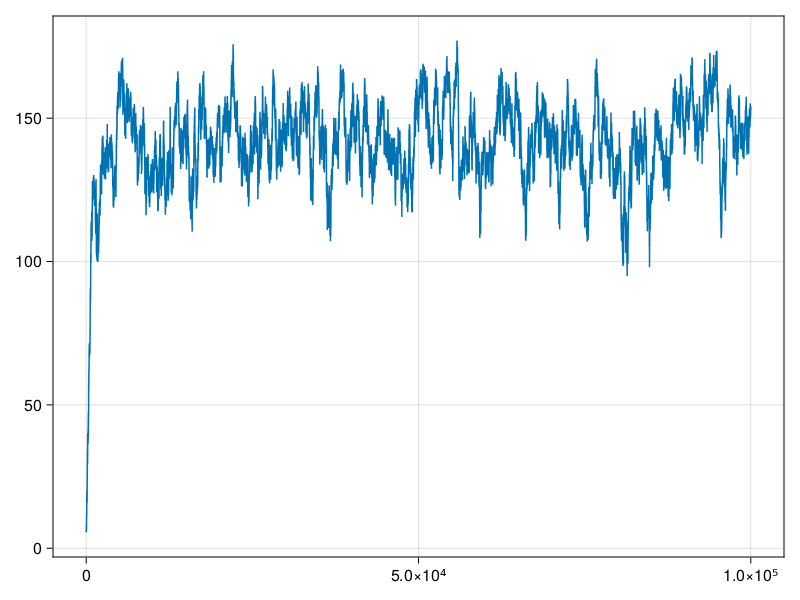

In [86]:
lines(chain[1][:, end])

In [110]:
x = reshape(mean(chain[1][50000:100000, 1:640], dims=1), 4, 160)

4×160 Matrix{Float64}:
  0.0146982   -0.0103807    0.00398053  …   0.0148545    0.00413783
 -0.0143643    0.00913476   0.0104349       0.00700947  -0.00585067
 -0.00257506   0.00103355   0.00555091      0.00473523   0.0111893
  0.00224121   0.00021239  -0.0199664      -0.0265992   -0.00947643

In [111]:
prob_mat = exp.(x) ./ sum(exp.(x), dims=1)
mut_info = sum([x * log2(x/0.25) for x in prob_mat], dims=1)

1×160 Matrix{Float64}:
 7.8293e-5  3.46386e-5  9.91479e-5  …  3.47485e-5  0.000178466  4.80828e-5

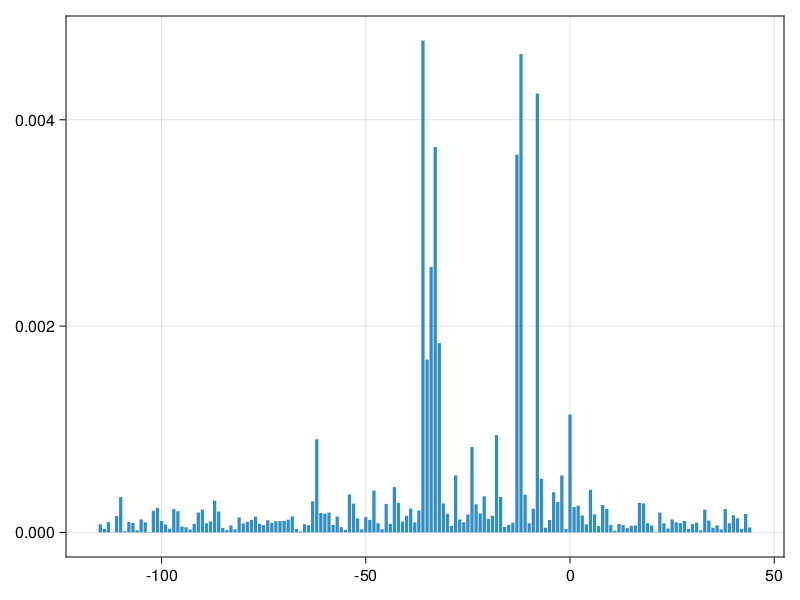

In [112]:
barplot(-115:44, mut_info|>vec)